<a href="https://colab.research.google.com/github/ockayy/forecasting-Budget/blob/main/Budget_forecasting3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## **Data Preparation**

In [13]:
# Load your dataset
df = pd.read_csv('Dataset.csv')

# Identify categorical columns
categorical_columns = ['pattern_type']  # Replace with the actual categorical column names if there are more

# One-Hot Encoding the categorical columns
encoder = OneHotEncoder(sparse=False)
encoded_categories = encoder.fit_transform(df[categorical_columns])

# Drop original categorical columns and add encoded categories
df = df.drop(categorical_columns, axis=1)
df_encoded = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_columns))
df = pd.concat([df, df_encoded], axis=1)

# Feature selection and scaling
# Adjust based on the actual columns present in your dataset
# Feature selection
features = df[['monthly_income', 'saving_goal', 'inflation_rate', 'cumulative_spend', 'remaining_income']]

# Multiple target selection
targets = df[['daily_spending', 'saving_achieved']]  # Predicting these three targets

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
targets_scaled = scaler.fit_transform(targets)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets_scaled, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# **LSTM MODEL**

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Initialize cell state with zeros
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # We need to ensure the input x is 3D (batch_size, sequence_length, input_size)
        # LSTM expects the input to have this shape, and x.size(0) represents batch_size
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[1]  # Number of features (4 in this case)
hidden_size = 50
num_layers = 2
output_size = y_train.shape[1]  # Number of targets (2 for predicting 2 things)

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)


# **Training Model**

In [23]:
# Hyperparameters
learning_rate = 0.0003 #updated with fine tuned one
num_epochs = 100
batch_size = 32

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Reshape input to be 3D (batch_size, sequence_length, input_size)
X_train = X_train.unsqueeze(1)  # Adding a sequence length of 1
X_test = X_test.unsqueeze(1)    # Adding a sequence length of 1

# Training Loop
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.1289
Epoch [20/100], Loss: 0.1220
Epoch [30/100], Loss: 0.1154
Epoch [40/100], Loss: 0.1087
Epoch [50/100], Loss: 0.1019
Epoch [60/100], Loss: 0.0948
Epoch [70/100], Loss: 0.0873
Epoch [80/100], Loss: 0.0796
Epoch [90/100], Loss: 0.0719
Epoch [100/100], Loss: 0.0647


# **Evaluation**

Test Loss: 0.0299


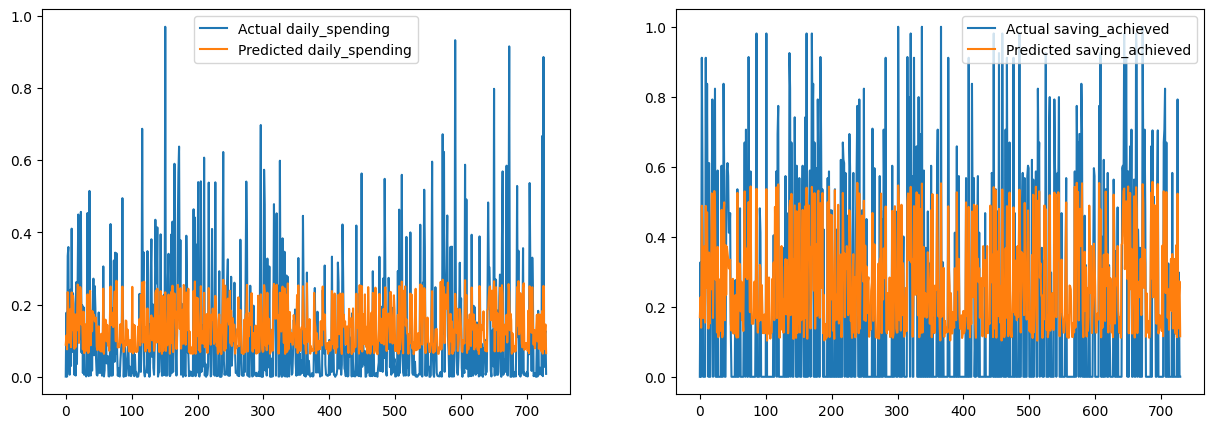

In [19]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

    print(f'Test Loss: {test_loss.item():.4f}')

# Plot predictions vs actuals for each target
plt.figure(figsize=(15, 5))
for i, target_name in enumerate(['daily_spending', 'saving_achieved']):
    plt.subplot(1, 2, i + 1)
    plt.plot(y_test[:, i].cpu().numpy(), label=f'Actual {target_name}')
    plt.plot(test_outputs[:, i].cpu().numpy(), label=f'Predicted {target_name}')
    plt.legend()
plt.show()


Prediction Consistency:

The predictions (orange lines) appear to be generally consistent but with a lower variance than the actual values (blue lines). This suggests that the model may be underfitting, meaning it isn’t capturing the full range of variability in the data.
Divergence in Peaks:

There are significant differences in the peaks between the actual and predicted values. The model doesn’t seem to capture the extreme values well, which could be critical depending on the importance of those peaks in your application.
Overlap and Central Tendency:

There is some overlap between the actual and predicted values, but the predictions seem to hover around a central range, missing the higher and lower extremes seen in the actual data.

# **Fine Tuning**

In [24]:
# Increase hidden size and number of layers
hidden_size = 300  # Increase from 100 to 200 to 300 now
num_layers = 4  # Increase the number of layers from 3 to 4


# Reinitialize the LSTM model with increased complexity
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003) #slower learning rate form '05 to '03

# Training Loop with Fine-Tuning
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0977
Epoch [20/100], Loss: 0.0807
Epoch [30/100], Loss: 0.0609
Epoch [40/100], Loss: 0.0588
Epoch [50/100], Loss: 0.0536
Epoch [60/100], Loss: 0.0482
Epoch [70/100], Loss: 0.0410
Epoch [80/100], Loss: 0.0315
Epoch [90/100], Loss: 0.0230
Epoch [100/100], Loss: 0.0195


Test Loss: 0.0194


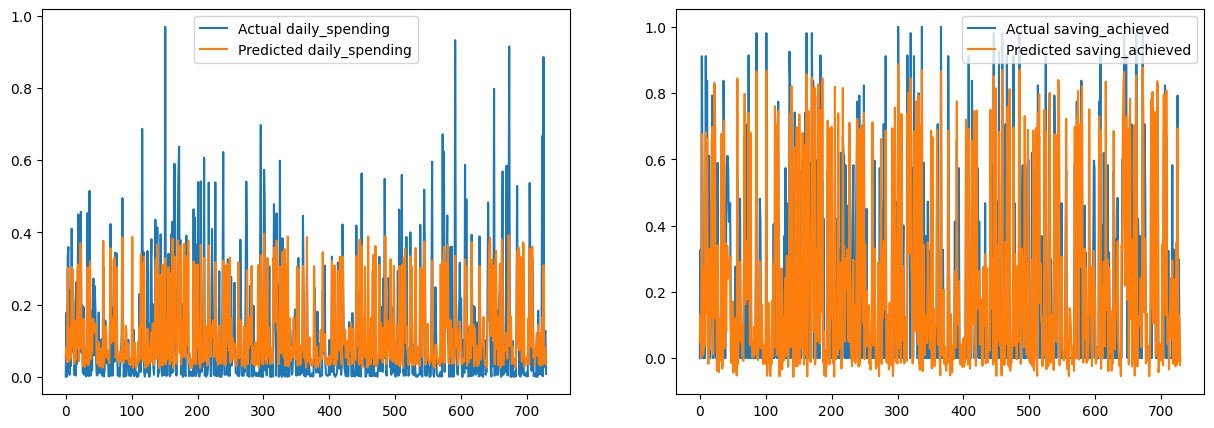

In [25]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

    print(f'Test Loss: {test_loss.item():.4f}')

# Plot predictions vs actuals for each target
plt.figure(figsize=(15, 5))
for i, target_name in enumerate(['daily_spending', 'saving_achieved']):
    plt.subplot(1, 2, i + 1)
    plt.plot(y_test[:, i].cpu().numpy(), label=f'Actual {target_name}')
    plt.plot(test_outputs[:, i].cpu().numpy(), label=f'Predicted {target_name}')
    plt.legend()
plt.show()


# Added dropout

In [25]:
class LSTMModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(LSTMModelWithDropout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.dropout(out[:, -1, :])  # Apply dropout before the fully connected layer
        out = self.fc(out)
        return out

# Parameters
hidden_size = 300  # Same as before
num_layers = 4     # Same as before
dropout_prob = 0.5  # Introduce dropout with 50% probability

# Initialize the model with dropout
model = LSTMModelWithDropout(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)  # Keep the learning rate the same

# Training Loop with Dropout
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0830
Epoch [20/100], Loss: 0.0703
Epoch [30/100], Loss: 0.0598
Epoch [40/100], Loss: 0.0585
Epoch [50/100], Loss: 0.0548
Epoch [60/100], Loss: 0.0488
Epoch [70/100], Loss: 0.0400
Epoch [80/100], Loss: 0.0283
Epoch [90/100], Loss: 0.0222
Epoch [100/100], Loss: 0.0222


Test Loss after introducing dropout: 0.0197


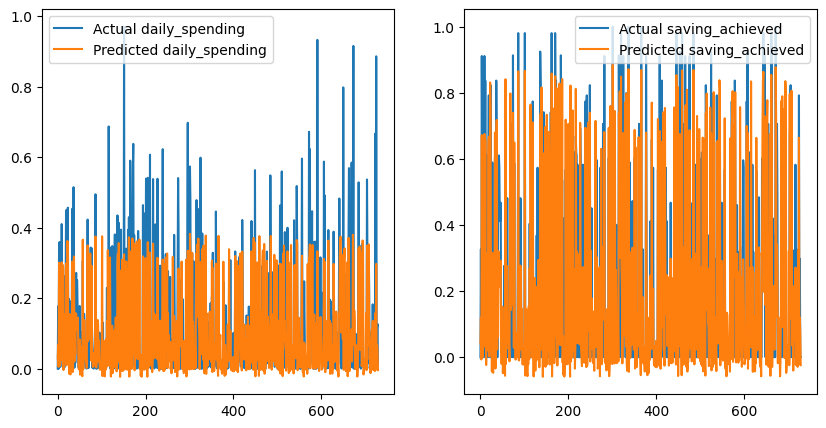

In [26]:
# Evaluate on test data with dropout
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    test_loss = criterion(outputs, y_test)

    print(f'Test Loss after introducing dropout: {test_loss.item():.4f}')

# Plot predictions vs actuals for each target after introducing dropout
plt.figure(figsize=(10, 5))
for i, target_name in enumerate(['daily_spending', 'saving_achieved']):
    plt.subplot(1, 2, i + 1)
    plt.plot(y_test[:, i].cpu().numpy(), label=f'Actual {target_name}')
    plt.plot(outputs[:, i].cpu().numpy(), label=f'Predicted {target_name}')
    plt.legend()
plt.show()


# **Export model**

In [33]:
import torch

# Define the path where you want to save the model
model_save_path = "budgetmodel.pth"

# Save both the model's and optimizer's state_dict
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item()
}, model_save_path)


print(f"Model and optimizer saved to {model_save_path}")


Model and optimizer saved to budgetmodel.pth


# **Testing with Console**

Welcome to the Financial Model Testing Console.
Model loaded successfully.
Enter your monthly income: 50000
Enter your saving goal for this month: 10000
Enter the current inflation rate (as a decimal): 11.10
Do you have previous spending data? (yes/no): yes
How many days of prior data do you have? 5
Enter amount spent on day 1: 123
Enter amount spent on day 2: 657
Enter amount spent on day 3: 435
Enter amount spent on day 4: 789
Enter amount spent on day 5: 1000


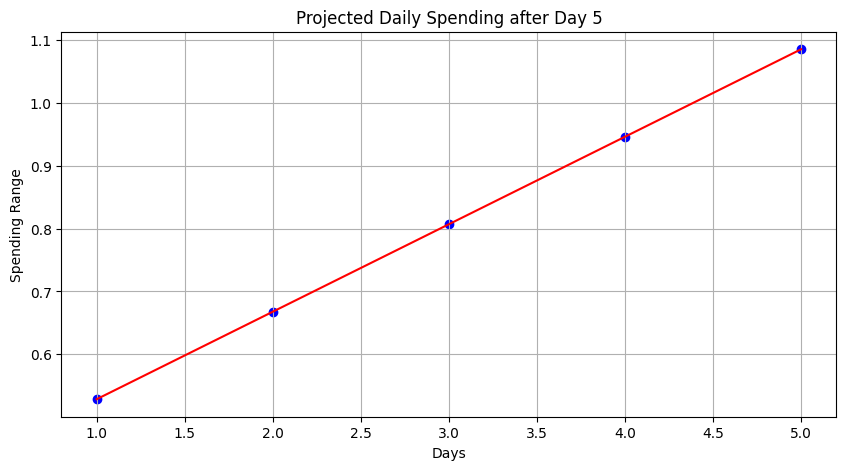

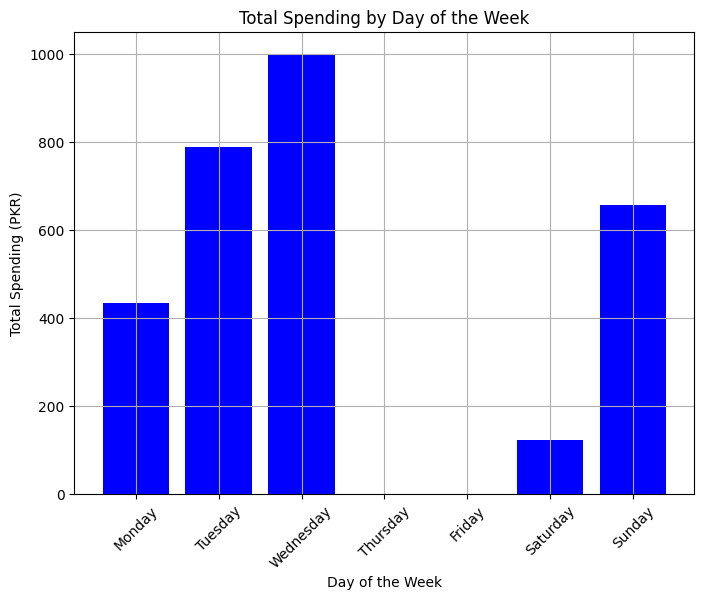

Predicted daily budget: 0.53 - 1.09
Do you agree with the suggested budget? (yes/no): no
Feedback saved to 'user_feedback.csv'.


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import datetime
import calendar
import os

# Assuming these are the means and standard deviations used during training for the output
mean_budget = 0.124639  # Example mean of budget during training
std_budget = 0.166042   # Example standard deviation of budget during training

# Load the trained model
def load_model(model_path):
    model = LSTMModelWithDropout(input_size=5, hidden_size=300, num_layers=4, output_size=2, dropout_prob=0.5)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # Set to evaluation mode
    print("Model loaded successfully.")
    return model

# Function to predict daily budget range
def predict_daily_budget(model, input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        output = model(input_tensor)
        return output.cpu().numpy()

# Denormalize the predicted output
def denormalize_output(predicted_budget):
    predicted_budget_denorm = predicted_budget * std_budget + mean_budget
    return predicted_budget_denorm

# Function to plot graphs without previous data
def plot_suggested_spending_pattern(income, saving_goal, days_in_month, spending_range):
    daily_budget = (income - saving_goal) / days_in_month

    days = np.arange(1, days_in_month + 1)
    spending_pattern = daily_budget * np.ones_like(days)

    plt.figure(figsize=(12, 6))

    plt.suptitle(f"Suggested Spending Range: {spending_range[0]:.2f} - {spending_range[1]:.2f}", fontsize=14)

    plt.subplot(3, 1, 1)
    plt.plot(days, spending_pattern, 'bo-', label='Daily Spending')
    plt.axhline(y=daily_budget, color='g', linestyle='--', label='Required Daily Spending')
    plt.title('Daily Spending Pattern')
    plt.xlabel('Day of Month')
    plt.ylabel('Amount Spent')
    plt.legend()

    plt.subplot(3, 1, 2)
    cumulative_spending = np.cumsum(spending_pattern)
    plt.plot(days, cumulative_spending, 'go-', label='Cumulative Spending')
    plt.title('Cumulative Spending Over the Month')
    plt.xlabel('Day of Month')
    plt.ylabel('Cumulative Amount Spent')
    plt.legend()

    plt.subplot(3, 1, 3)
    remaining_balance = income - cumulative_spending
    plt.plot(days, remaining_balance, 'ro-', label='Remaining Balance')
    plt.axhline(y=saving_goal, color='orange', linestyle='--', label='Desired Savings Goal')
    plt.title('Remaining Balance Over the Month')
    plt.xlabel('Day of Month')
    plt.ylabel('Remaining Balance')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot graphs with previous data
def plot_actual_vs_predicted(expenses, spending_range, days_in_month, min_budget, max_budget):
    days_remaining = np.arange(1, len(expenses) + 1)
    spending_projection = np.linspace(min_budget, max_budget, len(days_remaining))

    plt.figure(figsize=(10, 5))
    plt.scatter(days_remaining, spending_projection, color='blue')
    plt.plot(days_remaining, spending_projection, color='red')
    plt.title(f"Projected Daily Spending after Day {days_remaining[-1]}")
    plt.xlabel("Days")
    plt.ylabel("Spending Range")
    plt.grid(True)
    plt.show(block=False)
    plt.pause(1)  # Pause to allow graph display
    plt.close()

# Function to plot spending pattern by day of the week
def plot_spending_pattern_by_day(expenses, start_date):
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    days_of_week_indices = [(start_date + datetime.timedelta(days=i)).weekday() for i in range(len(expenses))]
    spending_by_day = [0] * 7

    for i, expense in enumerate(expenses):
        spending_by_day[days_of_week_indices[i]] += expense

    plt.figure(figsize=(8, 6))
    plt.bar(days_of_week, spending_by_day, color='blue')
    plt.title('Total Spending by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Total Spending (PKR)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Main function to handle user inputs and generate outputs
def main():
    print("Welcome to the Financial Model Testing Console.")

    # Load the model
    model_path = "budgetmodel.pth"  # Update with your model path
    model = load_model(model_path)

    monthly_income = float(input("Enter your monthly income: "))
    saving_goal = float(input("Enter your saving goal for this month: "))
    inflation_rate = float(input("Enter the current inflation rate (as a decimal): "))

    # Automatically determine the number of days in the current month
    today = datetime.date.today()
    days_in_month = calendar.monthrange(today.year, today.month)[1]

    # Scale inputs as done during training
    monthly_income_scaled = (monthly_income - mean_income) / std_income
    saving_goal_scaled = (saving_goal - mean_saving) / std_saving
    inflation_rate_scaled = (inflation_rate - mean_inflation) / std_inflation

    data_available = input("Do you have previous spending data? (yes/no): ").strip().lower()

    if data_available == 'no':
        print("No previous data available. Suggesting a spending pattern...")

        # Predict and display daily budget range
        input_data = np.array([monthly_income_scaled, saving_goal_scaled, 0, 0, inflation_rate_scaled])  # Include inflation as a feature
        predictions = predict_daily_budget(model, input_data)
        spending_range = denormalize_output(predictions[0])

        plot_suggested_spending_pattern(monthly_income, saving_goal, days_in_month, spending_range)
        print(f"Suggested daily budget: {spending_range[0]:.2f} - {spending_range[1]:.2f}")

    elif data_available == 'yes':
        num_days = int(input("How many days of prior data do you have? "))
        expenses = []
        for i in range(num_days):
            expense = float(input(f"Enter amount spent on day {i + 1}: "))
            expenses.append(expense)

        cumulative_spend = sum(expenses)
        start_date = today - datetime.timedelta(days=num_days)

        input_data = np.array([monthly_income_scaled, saving_goal_scaled, num_days, cumulative_spend, inflation_rate_scaled])  # Include inflation as a feature
        predictions = predict_daily_budget(model, input_data)
        spending_range = denormalize_output(predictions[0])

        min_budget, max_budget = spending_range

        plot_actual_vs_predicted(expenses, spending_range, days_in_month, min_budget, max_budget)
        plot_spending_pattern_by_day(expenses, start_date)

        print(f"Predicted daily budget: {spending_range[0]:.2f} - {spending_range[1]:.2f}")

    # Collect user feedback
    feedback = input("Do you agree with the suggested budget? (yes/no): ").strip().lower()

    # Save inputs, outputs, and feedback to a CSV file
    feedback_data = {
        'monthly_income': monthly_income,
        'saving_goal': saving_goal,
        'inflation_rate': inflation_rate,
        'num_days': num_days if data_available == 'yes' else 0,
        'cumulative_spend': cumulative_spend if data_available == 'yes' else 0,
        'predicted_budget_min': spending_range[0],
        'predicted_budget_max': spending_range[1],
        'feedback': feedback
    }

    # Check if the CSV exists, and write header only if it does not
    csv_file = 'user_feedback.csv'
    write_header = not os.path.exists(csv_file)

    feedback_df = pd.DataFrame([feedback_data])
    feedback_df.to_csv(csv_file, mode='a', header=write_header, index=False)
    print("Feedback saved to 'user_feedback.csv'.")

main()